In [6]:
import pprint
from datetime import date
import json
from intervalsicu import Intervals
import pandas as pd
import requests
from requests.auth import HTTPBasicAuth
from datetime import datetime, timedelta
import csv
from fitparse import FitFile
import os
import matplotlib.pyplot as plt
from imusensor.filters.kalman import Kalman
# import datetime
import pytz
import boto3


In [7]:


def plot_outdoor_ride(df, save_path = None):

    fig, ax1 = plt.subplots(figsize=(12, 10))
    ax2 = ax1.twinx()
    ax3 = ax1.twinx()

    ax1.plot(df.index, df['heart_rate'], color='brown', label='HR')
    ax2.plot(df.index, df['enhanced_altitude'], color='pink', label='Altitude')
    ax3.plot(df.index, df['enhanced_speed'], color='green', label='speed')

    ax1.set_ylabel('HR(bpm)')
    ax1.grid()

    ax2.set_ylabel('Altitude(m)')
    ax2.grid()
    ax3.set_ylabel('Speed(m/s)')
    ax3.grid()
    # ax3.legend()

    # combine the legends into one
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines3, labels3 = ax3.get_legend_handles_labels()
    ax1.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc='upper left')

    # plt.grid()
    if save_path:
        plt.savefig(save_path)
    else:
        plt.show() 


def plot_indoor_ride(df, save_path = None):

    fig, ax1 = plt.subplots(figsize=(12, 10))
    ax2 = ax1.twinx()
    ax3 = ax1.twinx()

    ax1.plot(df.index, df['power'], color='red', label='Power')
    ax2.plot(df.index, df['cadence'], color='blue', label='Cadence')
    ax3.plot(df.index, df['enhanced_speed'], color='green', label='Speed')

    ax1.set_ylabel('Power(W)')
    ax1.grid()

    ax2.set_ylabel('Cadence(rpm)')
    ax2.grid()
    ax3.set_ylabel('Speed(m/s)')
    ax3.grid()
    # ax3.legend()

    # combine the legends into one
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines3, labels3 = ax3.get_legend_handles_labels()
    ax1.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc='upper left')

    # plt.grid()
    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()  



In [8]:
env_file = "/hdd/side_projects/imu_project/env.json"
with open(env_file, 'r') as f:
    env_data = json.load(f)
    
headers = {
    "Authorization": f"Bearer {env_data['intervals_icu']['api_key']}"
}

athlete_id = env_data["intervals_icu"]["athlete_id"]
api_key = env_data["intervals_icu"]["api_key"]

# Base URL for the Intervals.icu API
base_url = "https://intervals.icu/api/v1"

# Function to get all events for the athlete
def get_all_activities():
    events_url = f"{base_url}/athlete/{athlete_id}/events.csv"
    response = requests.get(events_url, auth=HTTPBasicAuth('API_KEY', api_key))
    response.raise_for_status()  # Raise an error for bad status codes
    return response

def get_recent_activities(days=30):
    """
    Fetches activities from the current day up to 'days' days prior.

    Parameters:
    - days (int): Number of days to look back from today. Default is 30.

    Returns:
    - list: A list of activity dictionaries within the specified date range.
    """
    # Calculate date range
    end_date = datetime.now().date()
    start_date = end_date - timedelta(days=days)

    # Format dates in ISO 8601 format (YYYY-MM-DD)
    start_date_str = start_date.isoformat()
    end_date_str = end_date.isoformat()

    # Construct the API endpoint with query parameters
    activities_url = f"{base_url}/athlete/{athlete_id}/activities?oldest={start_date_str}&newest={end_date_str}"

    try:
        # Make the GET request to fetch activities
        response = requests.get(activities_url, auth=HTTPBasicAuth('API_KEY', api_key))
        response.raise_for_status()  # Raise an error for bad status codes
        activities = response.json()
        return activities
    except requests.exceptions.RequestException as e:
        print(f"An error occurred while fetching activities: {e}")
        return []

def download_fit_file(activity_id, save_path):
    """
    Downloads the FIT file for a given activity ID from Intervals.icu and saves it to the specified location.

    Parameters:
    - activity_id (str): The ID of the activity whose FIT file is to be downloaded.
    - save_path (str): The file path where the FIT file will be saved.
    - api_key (str): Your Intervals.icu API key.

    Returns:
    - None
    """
    # Construct the URL for the FIT file download
    fit_file_url = f"https://intervals.icu/api/v1/activity/{activity_id}/fit-file"

    try:
        # Make the GET request to download the FIT file
        response = requests.get(fit_file_url, auth=HTTPBasicAuth('API_KEY', api_key))
        response.raise_for_status()  # Raise an error for bad status codes

        # Save the FIT file to the specified location
        with open(save_path, 'wb') as fit_file:
            fit_file.write(response.content)
        print(f"FIT file successfully downloaded and saved to {save_path}")

    except requests.exceptions.RequestException as e:
        print(f"An error occurred while downloading the FIT file: {e}")

records_to_store = ['enhanced_speed', 'enhanced_altitude', 'cadence', 'power',
                    'heart_rate', 'timestamp', 'position_lat', 'position_long']

def fit_to_csv(fit_file_path, csv_file_path):
    """
    Converts a FIT file to a CSV file.

    Parameters:
    - fit_file_path: str, path to the input FIT file.
    - csv_file_path: str, path to the output CSV file.
    """
    # Load the FIT file
    fitfile = FitFile(fit_file_path)

    # Open the CSV file for writing
    with open(csv_file_path, mode='w', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)

        # Initialize a flag to write headers only once
        headers_written = False

        # Iterate over all messages of type 'record'
        for record in fitfile.get_messages('record'):
            record_data = {}

            # Extract data from each record
            for data in record:
                if data.name in records_to_store:
                    # print (data.name, data.value)
                    record_data[data.name] = data.value

            # Write the header row if not already written
            if not headers_written:
                headers = record_data.keys()
                csv_writer.writerow(headers)
                headers_written = True

            # Write the data row
            csv_writer.writerow(record_data.values())

    print(f"Conversion complete. CSV file saved as '{csv_file_path}'.")


# events = get_all_activities()

In [9]:
data_folder = "/hdd/side_projects/imu_project/data/garmin_data"
os.makedirs(data_folder, exist_ok=True)

acts = get_recent_activities(days=30)

bike_event_ids = []
indoor_bike_even_ids = []

for act in acts:
    if "ride" in act['type'].lower():
        bike_event_ids.append(act['id'])

for idx, act in enumerate(acts):
    if "ride" in act['type'].lower():
        event_id = act['id']
        timestamp = act['start_date_local']
        type = act['type']
        # convert the timestamp to YYYYMMDDHHMM
        timestamp = datetime.strptime(timestamp, '%Y-%m-%dT%H:%M:%S')
        timestamp = timestamp.strftime('%Y_%m_%d_%H%M')
        file_name = f"{data_folder}/{type}_{timestamp}_{event_id}.fit"
        
        if not os.path.exists(file_name):
            download_fit_file(event_id, file_name)
            fit_to_csv(file_name, file_name.replace(".fit", ".csv") )
    
    
    # elif "virtualride" in act['type'].lower():
    #     indoor_bike_even_ids.append(act['id'])


In [ ]:
# need a code to download sensor data from S3 
# first get a list of folders, if they are not present in the local data storage then, 
# pull them. 

env_file = "/hdd/side_projects/imu_project/form-check/aws.env"
with open(env_file, 'r') as f:
    env_data = json.load(f)
    
aws_access_key = env_data['accessKey']
aws_secret_key = env_data['secretKey']
aws_bucket_name = env_data['bucketName']
aws_region = env_data['region']

# get a list of folders in the bucket
s3 = boto3.client('s3', aws_access_key_id=aws_access_key, aws_secret_access_key=aws_secret_key, region_name=aws_region)

# print the list of folders
response = s3.list_objects_v2(Bucket=aws_bucket_name)
for obj in response['Contents']:
    print(obj['Key'])


local_data_folder = "/hdd/side_projects/imu_project/data/metawear_data/"
os.makedirs(local_data_folder, exist_ok=True)   
# check if the s3 files are present in the local data folder
for obj in response['Contents']:
    if obj['Key'] not in os.listdir(local_data_folder):
        local_file_path = os.path.join(local_data_folder, obj['Key'])
        os.makedirs(os.path.dirname(local_file_path), exist_ok=True)
        s3.download_file(aws_bucket_name, obj['Key'], local_file_path)

data/2025_04_08_20_19_31/accelerometer.csv
data/2025_04_08_20_19_31/gyroscope.csv
data/2025_04_08_20_19_31/magnetometer.csv
data/2025_04_08_20_20_42/accelerometer.csv
data/2025_04_08_20_20_42/gyroscope.csv
data/2025_04_08_20_20_42/magnetometer.csv
data/2025_04_08_20_33_01/accelerometer.csv
data/2025_04_08_20_33_01/gyroscope.csv
data/2025_04_08_20_33_01/magnetometer.csv
data/2025_04_08_20_34_23/accelerometer.csv
data/2025_04_08_20_34_23/gyroscope.csv
data/2025_04_08_20_34_23/magnetometer.csv
data/2025_04_08_20_35_19/accelerometer.csv
data/2025_04_08_20_35_19/gyroscope.csv
data/2025_04_08_20_35_19/magnetometer.csv
data/2025_04_08_20_36_16/accelerometer.csv
data/2025_04_08_20_36_16/gyroscope.csv
data/2025_04_08_20_36_16/magnetometer.csv
data/2025_04_08_20_38_07/accelerometer.csv
data/2025_04_08_20_38_07/gyroscope.csv
data/2025_04_08_20_38_07/magnetometer.csv
data/2025_04_08_20_39_29/accelerometer.csv
data/2025_04_08_20_39_29/gyroscope.csv
data/2025_04_08_20_39_29/magnetometer.csv
data/202

In [11]:
s3_data_folder = "/hdd/side_projects/imu_project/data/metawear_data/data/"
garmin_data_folder = "/hdd/side_projects/imu_project/data/garmin_data/"

# s3 data has folders like 2025_04_08_20_38_07, 2025_04_08_20_38_08, 2025_04_08_20_38_09, etc.
# and we need to open the accelerometer csv file in each of them and get the first timestamp and last timestamp. 

# similarly for garmin data, has files name_YYYY_MM_DD_HHMM_iID.csv
# open those files and get the first timestamp and last timestamp. change them to belgian time. 

# and now combine them such that for each garmin file, check which s3 folders have data for that time range. 

def convert_millis_to_datetime(millis):
    dt = datetime.fromtimestamp(millis/1000)
    formatted_time = dt.strftime('%Y-%m-%d %H:%M:%S')
    return formatted_time

def get_s3_folder_timestamps(folder_path):
    """Get first and last timestamp from accelerometer.csv in an S3 folder"""
    acc_file = os.path.join(folder_path, "accelerometer.csv")
    if not os.path.exists(acc_file):
        return None, None
    
    df = pd.read_csv(acc_file)
    if len(df) == 0:
        return None, None
        
    df['timestamp'] = df['timestamp'].apply(convert_millis_to_datetime)
    first_timestamp = df['timestamp'].iloc[0]
    last_timestamp = df['timestamp'].iloc[-1]
    return first_timestamp, last_timestamp

def get_garmin_file_timestamps(file_path):
    """Get first and last timestamp from a Garmin CSV file"""
    df = pd.read_csv(file_path)
    if len(df) == 0:
        return None, None
        
    first_timestamp = df['timestamp'].iloc[0]
    last_timestamp = df['timestamp'].iloc[-1]
    return first_timestamp, last_timestamp

def change_timestamp_to_belgian_time(timestamp):
    """Convert timestamp to Belgian time (Europe/Brussels)"""
    # Parse the timestamp
    dt = datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S')
    
    # Make it UTC aware
    utc = pytz.UTC
    dt = utc.localize(dt)
    
    # Convert to Belgian time (Europe/Brussels timezone)
    belgian_tz = pytz.timezone('Europe/Brussels')
    belgian_time = dt.astimezone(belgian_tz)
    
    return belgian_time.strftime('%Y-%m-%d %H:%M:%S')

# Process S3 folders
s3_folders = [f for f in os.listdir(s3_data_folder) if os.path.isdir(os.path.join(s3_data_folder, f))]
s3_timestamps = {}

for folder in s3_folders:
    folder_path = os.path.join(s3_data_folder, folder)
    first_ts, last_ts = get_s3_folder_timestamps(folder_path)
    if first_ts and last_ts:
        s3_timestamps[folder] = {
            'first_timestamp': first_ts,
            'last_timestamp': last_ts
        }

# Process Garmin files
garmin_files = [f for f in os.listdir(garmin_data_folder) if f.endswith('.csv')]
garmin_timestamps = {}

for file in garmin_files:
    file_path = os.path.join(garmin_data_folder, file)
    first_ts, last_ts = get_garmin_file_timestamps(file_path)
    if first_ts and last_ts:
        # Convert to Belgian time
        first_ts = change_timestamp_to_belgian_time(first_ts)
        last_ts = change_timestamp_to_belgian_time(last_ts)
        garmin_timestamps[file] = {
            'first_timestamp': first_ts,
            'last_timestamp': last_ts
        }

print (s3_timestamps)
print (garmin_timestamps)
# Match S3 folders to Garmin files
matches = {}
for garmin_file, garmin_ts in garmin_timestamps.items():
    matching_folders = []
    for s3_folder, s3_ts in s3_timestamps.items():
        # Check if S3 data overlaps with Garmin data
        if (s3_ts['first_timestamp'] <= garmin_ts['last_timestamp'] and 
            s3_ts['last_timestamp'] >= garmin_ts['first_timestamp']):
            matching_folders.append(s3_folder)
    matches[garmin_file] = matching_folders

# # Print results
print("Matching S3 folders for each Garmin file:")
for garmin_file, matching_folders in matches.items():
    print(f"\nGarmin file: {garmin_file}")
    print("Matching S3 folders:")
    for folder in matching_folders:
        print(f"- {folder}")


{'2025_04_08_20_36_16': {'first_timestamp': '2025-04-08 20:36:17', 'last_timestamp': '2025-04-08 20:36:52'}, '2025_04_08_20_33_01': {'first_timestamp': '2025-04-08 20:33:03', 'last_timestamp': '2025-04-08 20:33:52'}, '2025_04_08_22_00_40': {'first_timestamp': '2025-04-08 22:00:40', 'last_timestamp': '2025-04-08 22:00:58'}, '2025_04_09_17_46_18': {'first_timestamp': '2025-04-09 17:46:18', 'last_timestamp': '2025-04-09 17:48:24'}, '2025_04_08_20_38_07': {'first_timestamp': '2025-04-08 20:38:08', 'last_timestamp': '2025-04-08 20:39:01'}, '2025_04_09_17_51_58': {'first_timestamp': '2025-04-09 17:51:59', 'last_timestamp': '2025-04-09 17:58:39'}, '2025_04_08_20_20_42': {'first_timestamp': '2025-04-08 20:20:42', 'last_timestamp': '2025-04-08 20:21:12'}, '2025_04_09_17_59_45': {'first_timestamp': '2025-04-09 17:59:45', 'last_timestamp': '2025-04-09 18:26:35'}, '2025_04_08_20_35_19': {'first_timestamp': '2025-04-08 20:35:20', 'last_timestamp': '2025-04-08 20:35:52'}, '2025_04_08_20_39_29': {'fi

In [12]:
# garmin_file_name = 'VirtualRide_2025_04_08_2021_i73130063.csv'
# s3_folders = matches['VirtualRide_2025_04_08_2021_i73130063.csv']

garmin_file_name = 'Ride_2025_04_09_1751_i73270589.csv'
s3_folders = matches['Ride_2025_04_09_1751_i73270589.csv']

def get_kalman_orientation(row, kalman_filter):
    kalman_filter.computeAndUpdateRollPitch(row['x_acc'], row['y_acc'], row['z_acc'], row['x_gyro'], row['y_gyro'], 10)
    roll = kalman_filter.roll
    pitch = kalman_filter.pitch
    return roll, pitch

def process_s3_folder(s3_data_folder, s3_folder):
    imu_data = []
    csv_files = sorted([f for f in os.listdir(os.path.join(s3_data_folder, s3_folder)) if f.endswith('.csv') ])
    acc_df = pd.read_csv(os.path.join(os.path.join(s3_data_folder, s3_folder), csv_files[0]))
    gyro_df = pd.read_csv(os.path.join(os.path.join(s3_data_folder, s3_folder), csv_files[1]))
    mag_df = pd.read_csv(os.path.join(os.path.join(s3_data_folder, s3_folder), csv_files[2]))
    merged_df = pd.merge(acc_df, gyro_df, on='timestamp', how='inner', suffixes=('_acc', '_gyro'))
    Kalman_filter = Kalman()
    merged_df['roll'], merged_df['pitch'] = zip(*merged_df.apply(lambda row: get_kalman_orientation(row, Kalman_filter), axis=1))
    merged_df['timestamp'] = merged_df['timestamp'].apply(convert_millis_to_datetime)
    merged_df['timestamp'] = pd.to_datetime(merged_df['timestamp'])
    return merged_df

imu_dfs = []
for s3_folder in s3_folders:
    imu_data = process_s3_folder(s3_data_folder, s3_folder)
    imu_dfs.append(imu_data)

# process the garmin file
garmin_df = pd.read_csv(os.path.join(garmin_data_folder, garmin_file_name))
garmin_df['timestamp'] = garmin_df['timestamp'].apply(change_timestamp_to_belgian_time)
garmin_df['timestamp'] = pd.to_datetime(garmin_df['timestamp'])

/tmp/ipykernel_2167477/822276315.py:26: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  imu_df_grouped = imu_df.groupby(pd.Grouper(key='timestamp', freq='50S'))[columns].agg(
/tmp/ipykernel_2167477/822276315.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  garmin_df_filtered['speed_kmh'] = garmin_df_filtered['enhanced_speed'] * 3.6
/tmp/ipykernel_2167477/822276315.py:36: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  garmin_df_filtered = garmin_df_filtered.groupby(pd.Grouper(key='timestamp', freq='50S'))[['speed_kmh', 'heart_rate']].agg(
/tmp/ipykernel_2167477/822276315.py:26: FutureWarning: 'S' is deprecated and will be removed in a futur

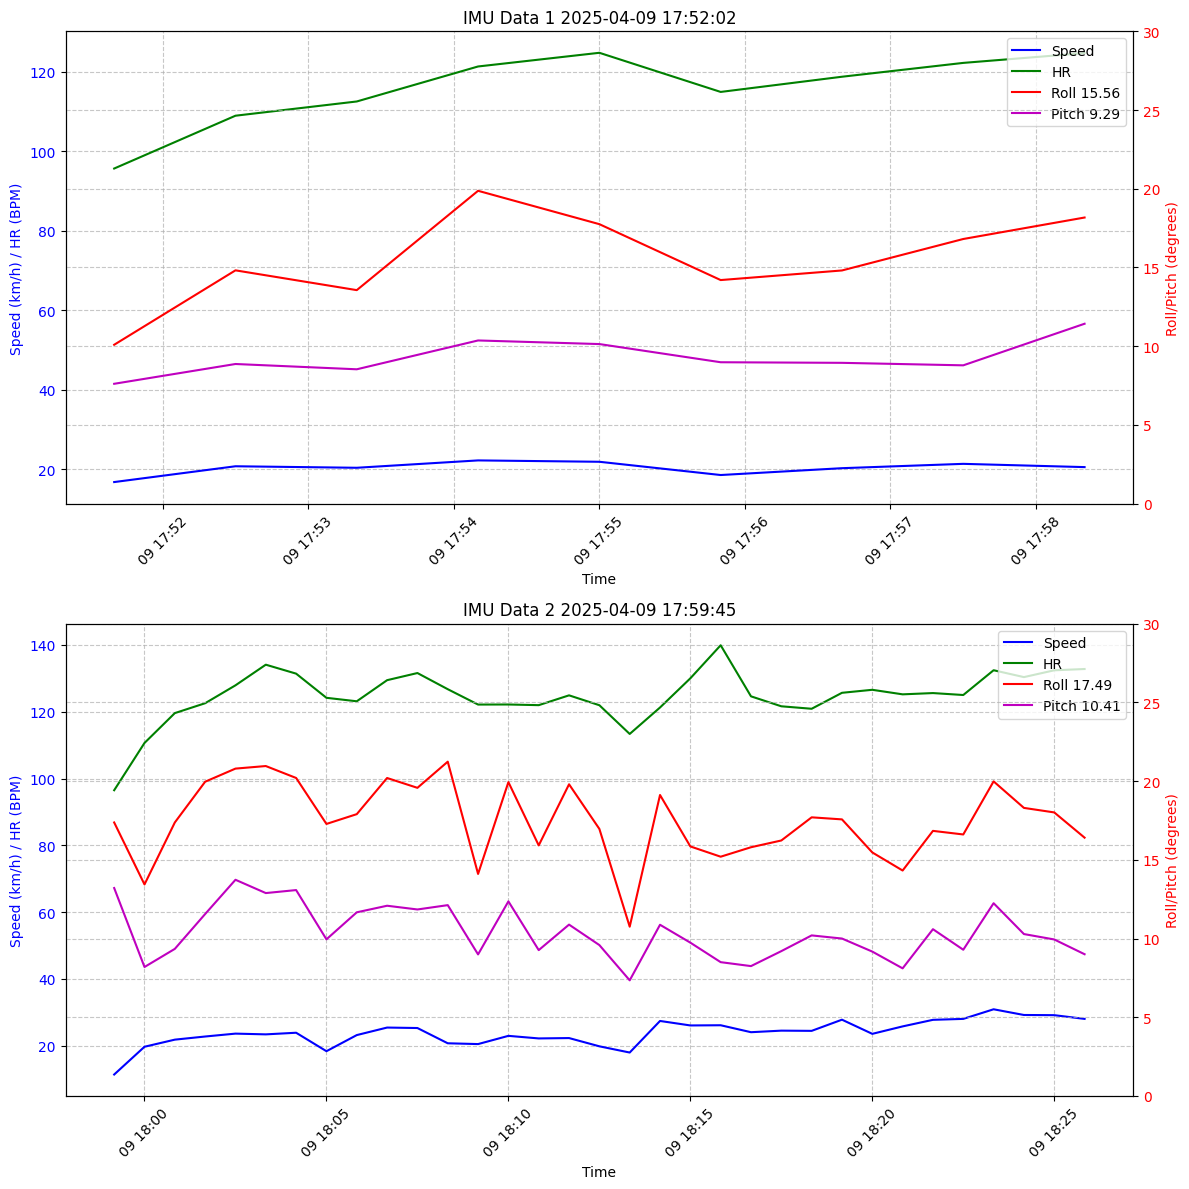

In [13]:
def plot_imu_garmin_comparison(imu_dfs, garmin_df):
    """
    Plot comparison between IMU and Garmin data for multiple IMU dataframes.
    
    Args:
        imu_dfs (list): List of IMU dataframes
        garmin_df (pd.DataFrame): Garmin dataframe with power and cadence data
    """
    # Create figure with subplots
    n_plots = len(imu_dfs)
    fig, axes = plt.subplots(n_plots, 1, figsize=(12, 6*n_plots))
    
    # If there's only one plot, make axes a list for consistency
    if n_plots == 1:
        axes = [axes]
    
    for idx, imu_df in enumerate(imu_dfs):
        # Filter Garmin data for this IMU dataframe's time range
        start_timestamp = imu_df['timestamp'].iloc[0]
        end_timestamp = imu_df['timestamp'].iloc[-1]
        garmin_df_filtered = garmin_df[(garmin_df['timestamp'] >= start_timestamp) & 
                                     (garmin_df['timestamp'] <= end_timestamp)]
        
        columns = ['roll', 'pitch']
        # Group IMU data by 1-second intervals
        imu_df_grouped = imu_df.groupby(pd.Grouper(key='timestamp', freq='50S'))[columns].agg(
            lambda x: x.quantile(0.75) - x.quantile(0.25)
        )
        
        # Get current axis
        ax1 = axes[idx]
        
        garmin_df_filtered['speed_kmh'] = garmin_df_filtered['enhanced_speed'] * 3.6
        
        # 5 seconds aggregate for garmin data
        garmin_df_filtered = garmin_df_filtered.groupby(pd.Grouper(key='timestamp', freq='50S'))[['speed_kmh', 'heart_rate']].agg(
            lambda x: x.mean()
        )
        
        # Plot power and cadence on left y-axis
        ax1.plot(garmin_df_filtered.index, garmin_df_filtered['speed_kmh'], 'b-', label='Speed')
        ax1.plot(garmin_df_filtered.index, garmin_df_filtered['heart_rate'], 'g-', label='HR')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Speed (km/h) / HR (BPM)', color='b')
        ax1.tick_params(axis='y', labelcolor='b')
        
        # Create second y-axis for roll and pitch
        ax2 = ax1.twinx()
        ax2.plot(imu_df_grouped.index, imu_df_grouped['roll'], 'r-', label=f'Roll {imu_df_grouped["roll"].mean():.2f}')
        ax2.plot(imu_df_grouped.index, imu_df_grouped['pitch'], 'm-', label=f'Pitch {imu_df_grouped["pitch"].mean():.2f}')
        ax2.set_ylabel('Roll/Pitch (degrees)', color='r')
        ax2.tick_params(axis='y', labelcolor='r')
        ax2.set_ylim(0, 30)  # Set y-axis limits for roll and pitch
        
        # Make grid lines more visible
        ax1.grid(True, linestyle='--', alpha=0.7)
        ax2.grid(True, linestyle='--', alpha=0.7)
        
        # Add legend
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
        
        # Format x-axis
        plt.setp(ax1.get_xticklabels(), rotation=45)
        
        # Add title for each subplot
        ax1.set_title(f'IMU Data {idx+1} {start_timestamp}')
    
    # Adjust layout
    plt.tight_layout()
    
    # Show plot
    plt.show()
plot_imu_garmin_comparison(imu_dfs, garmin_df)

/tmp/ipykernel_2167477/2800363374.py:7: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  frame_rate = imu_dfs[0].groupby(pd.Grouper(key='timestamp', freq='1S')).size()
/tmp/ipykernel_2167477/2800363374.py:15: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  frame_rate = imu_dfs[0].groupby(pd.Grouper(key='timestamp', freq='1S')).size()


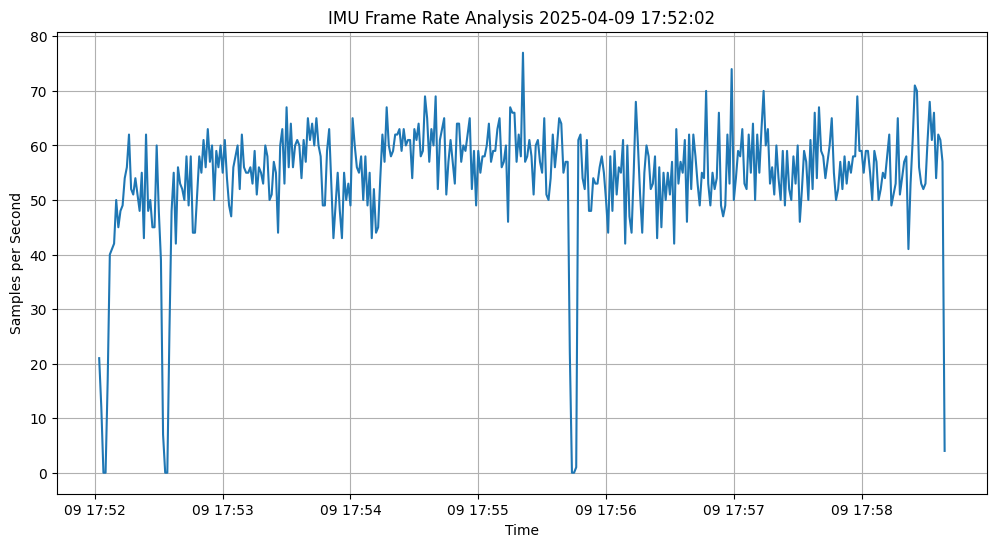

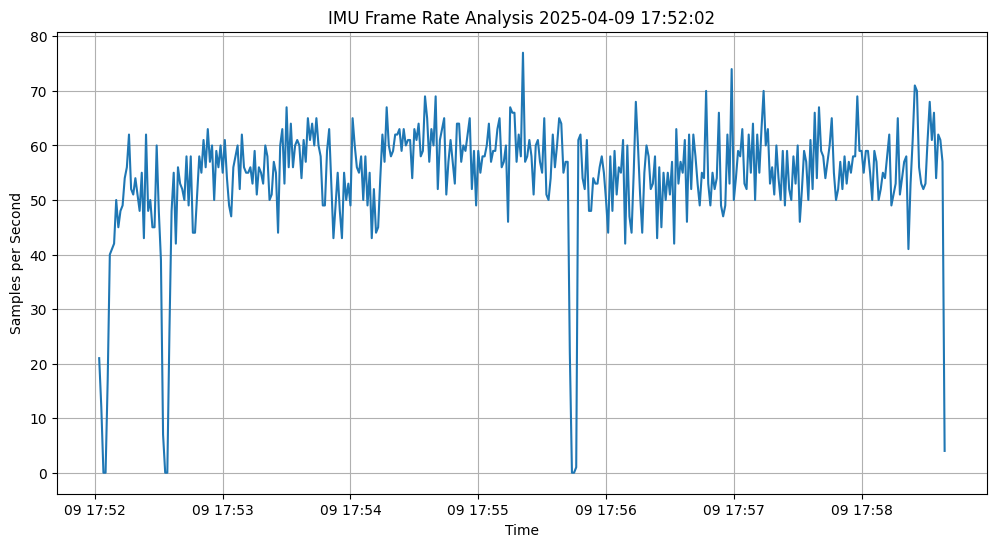

In [14]:
imu_dfs[0].head()

# find the frame rate dropping, 
# group the data by 1 second and count the number of rows in each group
# plot the number of rows in each group

frame_rate = imu_dfs[0].groupby(pd.Grouper(key='timestamp', freq='1S')).size()

imu_dfs[0].head()

# find the frame rate dropping, 
# group the data by 1 second and count the number of rows in each group
# plot the number of rows in each group

frame_rate = imu_dfs[0].groupby(pd.Grouper(key='timestamp', freq='1S')).size()



# Create frame rate drop analysis plot
plt.figure(figsize=(12, 6))
plt.plot(frame_rate.index, frame_rate.values)
plt.title(f'IMU Frame Rate Analysis {imu_dfs[0]["timestamp"].iloc[0]}')
plt.xlabel('Time')
plt.ylabel('Samples per Second')
plt.grid(True)

# Create frame rate drop analysis plot
plt.figure(figsize=(12, 6))
plt.plot(frame_rate.index, frame_rate.values)
plt.title(f'IMU Frame Rate Analysis {imu_dfs[0]["timestamp"].iloc[0]}')
plt.xlabel('Time')
plt.ylabel('Samples per Second')
plt.grid(True)
